In [1]:
# install.packages("NeuralNetTools")

In [58]:
# libraries
library(readxl)
options(warn = 0)
library(tidyverse)
library(readxl)
library(lubridate)
library(zoo)
library(readxl)
library(neuralnet)
library(knitr)
library(Metrics)
library(NeuralNetTools)

In [3]:
df <- read_excel("data/UOW_load.xlsx")
head(df)

Dates,09:00,10:00,11:00
<dttm>,<dbl>,<dbl>,<dbl>
2018-01-01,89.4,90.6,88.6
2018-01-02,108.2,104.6,106.0
2018-01-03,110.0,111.6,114.8
2018-01-04,106.4,104.4,109.0
2018-01-05,97.8,100.4,102.4
2018-01-06,87.0,90.8,87.2


In [4]:
df$Dates<-as.Date(df$Dates)

In [5]:
names(df)[2] <- paste("ninth_hour")
names(df)[3] <- paste("tenth_hour")
names(df)[4] <- paste("eleventh_hour")
head(df)

Dates,ninth_hour,tenth_hour,eleventh_hour
<date>,<dbl>,<dbl>,<dbl>
2018-01-01,89.4,90.6,88.6
2018-01-02,108.2,104.6,106.0
2018-01-03,110.0,111.6,114.8
2018-01-04,106.4,104.4,109.0
2018-01-05,97.8,100.4,102.4
2018-01-06,87.0,90.8,87.2


In [6]:
summary(df[2:4])

   ninth_hour       tenth_hour     eleventh_hour   
 Min.   : 50.40   Min.   : 49.20   Min.   : 48.20  
 1st Qu.: 81.55   1st Qu.: 83.00   1st Qu.: 84.75  
 Median : 97.50   Median :102.80   Median :105.40  
 Mean   : 95.35   Mean   : 99.63   Mean   :102.83  
 3rd Qu.:110.60   3rd Qu.:116.05   3rd Qu.:120.90  
 Max.   :141.20   Max.   :148.80   Max.   :156.40  

In [7]:
# insert all the inputs to the one data frame
# creating revious time frame values for autoregressive model 
df_full = df %>%
 mutate(
    nine_lag_1 = lag(df$ninth_hour,1),
    ten_lag_1 = lag(df$tenth_hour,1),
    nine_lag_2 = lag(df$ninth_hour,2),
    ten_lag_2 = lag(df$tenth_hour,2),
    eleven_lag_1 = lag(df$eleventh_hour,1),
    eleven_lag_2 = lag(df$eleventh_hour,2),
    eleven_lag_3 = lag(df$eleventh_hour,3),
    eleven_lag_4 = lag(df$eleventh_hour,4),
    #roll mean
    nine_rollmean_4 = rollmean(ninth_hour,4, fill = NA),
    nine_rollmean_7 = rollmean(ninth_hour,7, fill = NA),
    ten_rollmean_4 = rollmean(tenth_hour,4, fill = NA),
    ten_rollmean_7 = rollmean(tenth_hour,7, fill = NA),
    eleven_rollmean_4 = rollmean(eleventh_hour,4, fill = NA),
    eleven_rollmean_7 = rollmean(eleventh_hour,7, fill = NA)) %>%
#Drop null coulumns
drop_na()


In [8]:
head(df_full)

Dates,ninth_hour,tenth_hour,eleventh_hour,nine_lag_1,ten_lag_1,nine_lag_2,ten_lag_2,eleven_lag_1,eleven_lag_2,eleven_lag_3,eleven_lag_4,nine_rollmean_4,nine_rollmean_7,ten_rollmean_4,ten_rollmean_7,eleven_rollmean_4,eleven_rollmean_7
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-05,97.8,100.4,102.4,106.4,104.4,110.0,111.6,109.0,114.8,106.0,88.6,90.00,98.34286,90.65,98.82857,91.55,100.4571
2018-01-06,87.0,90.8,87.2,97.8,100.4,106.4,104.4,102.4,109.0,114.8,106.0,90.95,98.77143,92.80,100.91429,93.35,101.8857
2018-01-07,68.8,67.0,67.6,87.0,90.8,97.8,100.4,87.2,102.4,109.0,114.8,94.30,98.62857,97.50,101.34286,96.75,101.8000
2018-01-08,110.2,113.0,116.2,68.8,67.0,87.0,90.8,67.6,87.2,102.4,109.0,99.80,97.68571,103.45,102.00000,103.50,102.4286
2018-01-09,111.2,119.2,116.0,110.2,113.0,68.8,67.0,116.2,67.6,87.2,102.4,107.55,99.57143,113.95,104.05714,114.95,105.0000
2018-01-10,109.0,114.6,114.2,111.2,119.2,110.2,113.0,116.0,116.2,67.6,87.2,107.75,99.77143,114.40,103.88571,116.00,104.6571


## Input vercors

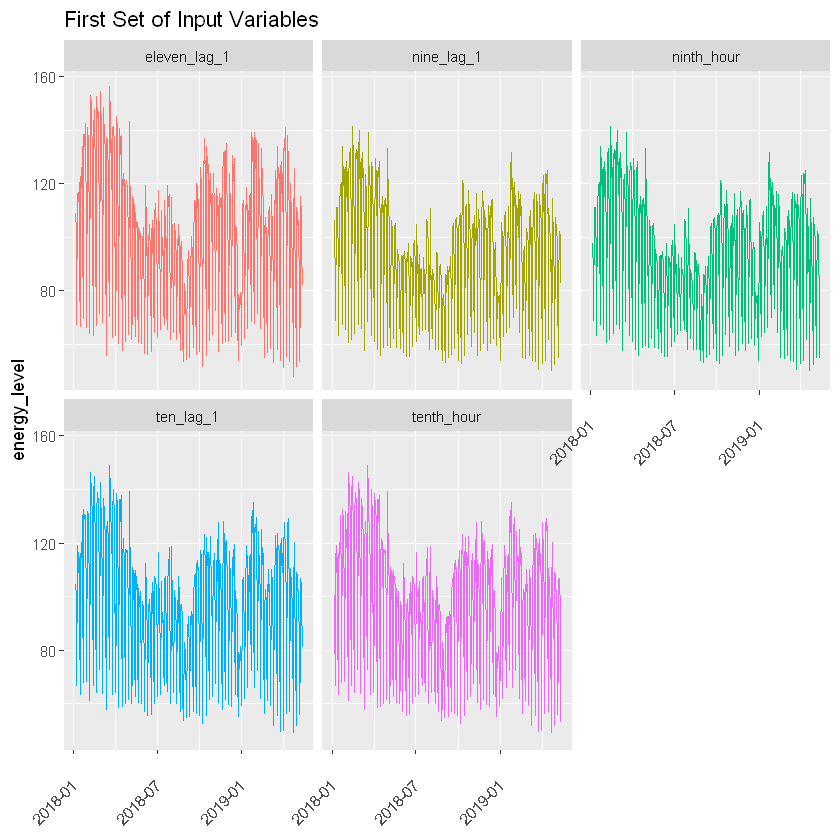

In [9]:
#1st lag
df_full %>%
pivot_longer(cols = c(2, 3, 5, 6, 9), names_to = "kind", values_to = "energy_level") %>%
ggplot(aes(Dates, energy_level, color = kind)) +
geom_line() +
facet_wrap(~kind) + theme(axis.text.x = element_text(angle = 45, vjust =
0.5, hjust = 1
)) +
labs(x = "",
title = "First Set of Input Variables") +
theme(legend.position = "none")


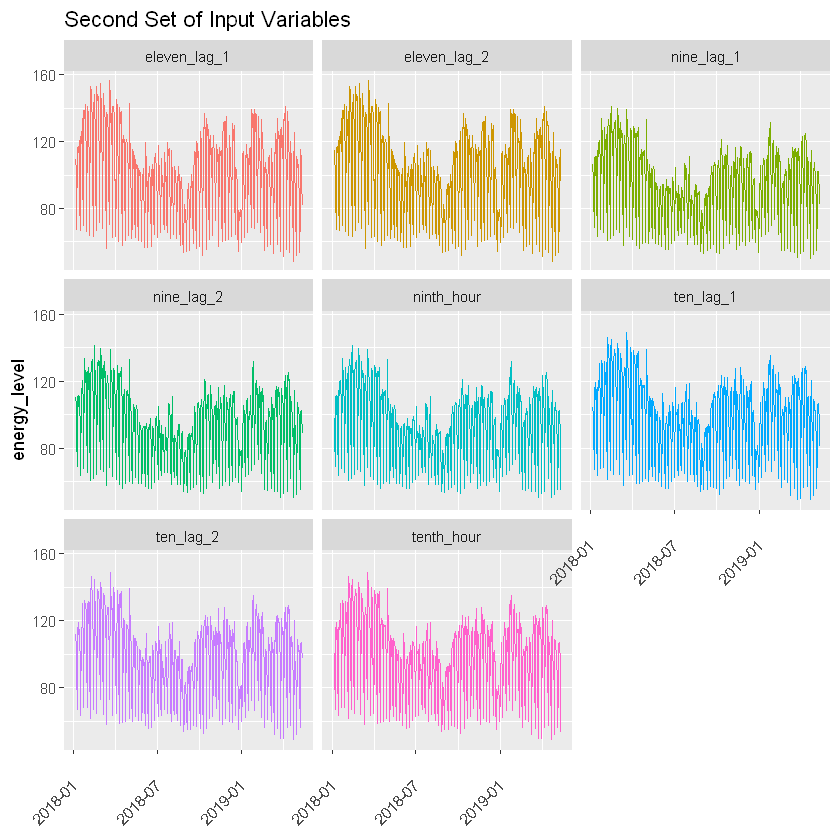

In [10]:
#2nd lag
df_full %>%
pivot_longer(cols = c(2, 3, 5, 6, 9, 7, 8, 10), names_to = "kind", values_to = "energy_level") %>%
ggplot(aes(Dates, energy_level, color = kind)) +
geom_line() +
facet_wrap(~kind) + theme(axis.text.x = element_text(angle = 45, vjust =
0.5, hjust = 1
)) +
labs(x = "",
title = "Second Set of Input Variables") +
theme(legend.position = "none")

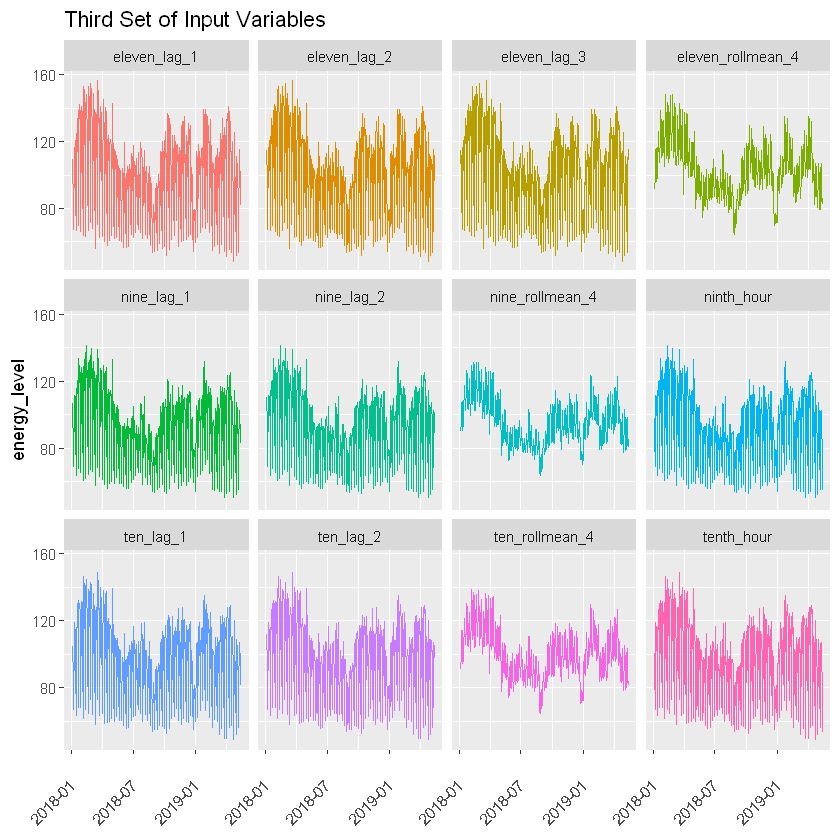

In [11]:
#3rd lag
df_full %>%
pivot_longer(cols = c(2, 3, 5, 6, 9, 7, 8, 10, 11, 13, 15, 17), names_to = "kind", values_to = "energy_level") %>%
ggplot(aes(Dates, energy_level, color = kind)) +
geom_line() +
facet_wrap(~kind) + theme(axis.text.x = element_text(angle = 45, vjust =
0.5, hjust = 1
)) +
labs(x = "",
title = "Third Set of Input Variables") +
theme(legend.position = "none")

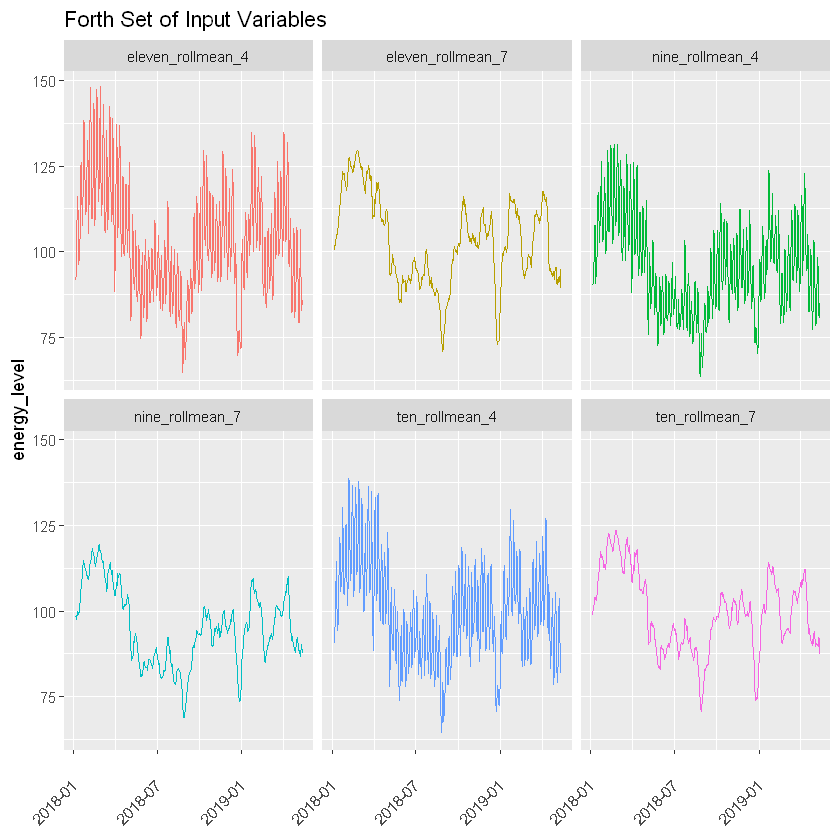

In [12]:
#4thd lag
df_full %>%
pivot_longer(cols = c(13, 14, 15, 16, 17, 18), names_to = "kind", values_to = "energy_level") %>%
ggplot(aes(Dates, energy_level, color = kind)) +
geom_line() +
facet_wrap(~kind) + theme(axis.text.x = element_text(angle = 45, vjust =
0.5, hjust = 1
)) +
labs(x = "",
title = "Forth Set of Input Variables") +
theme(legend.position = "none")

# Data Normalization

In [13]:
head(df_full)

Dates,ninth_hour,tenth_hour,eleventh_hour,nine_lag_1,ten_lag_1,nine_lag_2,ten_lag_2,eleven_lag_1,eleven_lag_2,eleven_lag_3,eleven_lag_4,nine_rollmean_4,nine_rollmean_7,ten_rollmean_4,ten_rollmean_7,eleven_rollmean_4,eleven_rollmean_7
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-05,97.8,100.4,102.4,106.4,104.4,110.0,111.6,109.0,114.8,106.0,88.6,90.00,98.34286,90.65,98.82857,91.55,100.4571
2018-01-06,87.0,90.8,87.2,97.8,100.4,106.4,104.4,102.4,109.0,114.8,106.0,90.95,98.77143,92.80,100.91429,93.35,101.8857
2018-01-07,68.8,67.0,67.6,87.0,90.8,97.8,100.4,87.2,102.4,109.0,114.8,94.30,98.62857,97.50,101.34286,96.75,101.8000
2018-01-08,110.2,113.0,116.2,68.8,67.0,87.0,90.8,67.6,87.2,102.4,109.0,99.80,97.68571,103.45,102.00000,103.50,102.4286
2018-01-09,111.2,119.2,116.0,110.2,113.0,68.8,67.0,116.2,67.6,87.2,102.4,107.55,99.57143,113.95,104.05714,114.95,105.0000
2018-01-10,109.0,114.6,114.2,111.2,119.2,110.2,113.0,116.0,116.2,67.6,87.2,107.75,99.77143,114.40,103.88571,116.00,104.6571


In [14]:
summary(df_full)

     Dates              ninth_hour       tenth_hour     eleventh_hour  
 Min.   :2018-01-05   Min.   : 50.40   Min.   : 49.20   Min.   : 48.2  
 1st Qu.:2018-05-08   1st Qu.: 81.20   1st Qu.: 83.00   1st Qu.: 84.6  
 Median :2018-09-08   Median : 97.40   Median :102.80   Median :105.2  
 Mean   :2018-09-08   Mean   : 95.28   Mean   : 99.65   Mean   :102.9  
 3rd Qu.:2019-01-09   3rd Qu.:110.60   3rd Qu.:116.20   3rd Qu.:121.2  
 Max.   :2019-05-12   Max.   :141.20   Max.   :148.80   Max.   :156.4  
   nine_lag_1       ten_lag_1        nine_lag_2       ten_lag_2     
 Min.   : 50.40   Min.   : 49.20   Min.   : 50.40   Min.   : 49.20  
 1st Qu.: 81.40   1st Qu.: 83.00   1st Qu.: 81.40   1st Qu.: 83.20  
 Median : 97.60   Median :102.80   Median : 97.60   Median :103.00  
 Mean   : 95.38   Mean   : 99.75   Mean   : 95.44   Mean   : 99.82  
 3rd Qu.:110.60   3rd Qu.:116.20   3rd Qu.:110.60   3rd Qu.:116.20  
 Max.   :141.20   Max.   :148.80   Max.   :141.20   Max.   :148.80  
  eleven_lag_

##### min-max normalization

In [15]:
min_max_normalize <- function(x) {
return ((x - min(x)) / (max(x) - min(x))) }


unnormalize_eleventh_hour <- function(x) {
return( (max(df_full$eleventh_hour) - min(df_full$eleventh_hour))*x + min(df_full$eleventh_hour)) }


In [16]:
df_normalized <- as.data.frame(lapply(df_full[2:18], min_max_normalize))
head(df_normalized)

,ninth_hour,tenth_hour,eleventh_hour,nine_lag_1,ten_lag_1,nine_lag_2,ten_lag_2,eleven_lag_1,eleven_lag_2,eleven_lag_3,eleven_lag_4,nine_rollmean_4,nine_rollmean_7,ten_rollmean_4,ten_rollmean_7,eleven_rollmean_4,eleven_rollmean_7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5220264,0.5140562,0.5009242,0.6167401,0.5542169,0.6563877,0.6265060,0.5619224,0.6155268,0.5341959,0.3733826,0.3892171,0.5839457,0.3517520,0.5317888,0.3217910,0.5036425
2,0.4030837,0.4176707,0.3604436,0.5220264,0.5140562,0.6167401,0.5542169,0.5009242,0.5619224,0.6155268,0.5341959,0.4032496,0.5924251,0.3807278,0.5711207,0.3432836,0.5279262
3,0.2026432,0.1787149,0.1792976,0.4030837,0.4176707,0.5220264,0.5140562,0.3604436,0.5009242,0.5619224,0.6155268,0.4527326,0.5895986,0.4440701,0.5792026,0.3838806,0.5264692
4,0.6585903,0.6405622,0.6284658,0.2026432,0.1787149,0.4030837,0.4176707,0.1792976,0.3604436,0.5009242,0.5619224,0.5339734,0.5709440,0.5242588,0.5915948,0.4644776,0.5371540
5,0.6696035,0.7028112,0.6266174,0.6585903,0.6405622,0.2026432,0.1787149,0.6284658,0.1792976,0.3604436,0.5009242,0.6484490,0.6082533,0.6657682,0.6303879,0.6011940,0.5808645
6,0.6453744,0.6566265,0.6099815,0.6696035,0.7028112,0.6585903,0.6405622,0.6266174,0.6284658,0.1792976,0.3604436,0.6514032,0.6122103,0.6718329,0.6271552,0.6137313,0.5750364


In [17]:
summary(df_normalized)

   ninth_hour       tenth_hour     eleventh_hour      nine_lag_1    
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.3392   1st Qu.:0.3394   1st Qu.:0.3364   1st Qu.:0.3414  
 Median :0.5176   Median :0.5382   Median :0.5268   Median :0.5198  
 Mean   :0.4943   Mean   :0.5065   Mean   :0.5052   Mean   :0.4954  
 3rd Qu.:0.6630   3rd Qu.:0.6727   3rd Qu.:0.6747   3rd Qu.:0.6630  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
   ten_lag_1        nine_lag_2       ten_lag_2       eleven_lag_1   
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.3394   1st Qu.:0.3414   1st Qu.:0.3414   1st Qu.:0.3383  
 Median :0.5382   Median :0.5198   Median :0.5402   Median :0.5305  
 Mean   :0.5076   Mean   :0.4960   Mean   :0.5082   Mean   :0.5063  
 3rd Qu.:0.6727   3rd Qu.:0.6630   3rd Qu.:0.6727   3rd Qu.:0.6747  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
  eleven_lag_2     eleven_lag_3   

In [18]:
dim(df_normalized)

[1] 493  17

In [19]:
set.seed(123)
df_train <- df_normalized[1:430,]
df_test <- df_normalized[431:493,]

In [20]:
model_one_hidden_layer = function(arg, hidden_first, activation_fun, learning_rate, test_data, model_type) {
    one_layer_nurelnet = neuralnet(arg,
    data=df_train, 
    hidden = c(hidden_first), 
    linear.output = TRUE, 
    act.fct = activation_fun,
    learningrate = learning_rate,
    algorithm = "rprop+"
    )
    results = compute(one_layer_nurelnet, test_data)
    truth_column = df_full[431:493, 4]$eleventh_hour
    predicted_column =  unnormalize_eleventh_hour(results$net.result)[,1]
      
    results <- data.frame(
        model_type = model_type, 
        hidden_layers = hidden_first, 
        RMSE = rmse(truth_column,predicted_column), 
        MAE = mae(truth_column, predicted_column), 
        MAPE =mape(truth_column, predicted_column),
        act_function = activation_fun,
        learning_rate = learning_rate)
}

In [21]:
model_two_hidden_layer = function(arg, hidden_first, hidden_second, activation_fun, learning_rate, test_data, model_type) {
    two_layer_nurelnet = neuralnet(arg,
    data=df_train, 
    hidden = c(hidden_first, hidden_second), 
    linear.output = TRUE, 
    act.fct = activation_fun,
    learningrate = learning_rate,
    algorithm = "rprop+"
    )
    results = compute(two_layer_nurelnet, test_data)
    truth_column = df_full[431:493, 4]$eleventh_hour
    predicted_column =  unnormalize_eleventh_hour(results$net.result)[,1]

    results <- data.frame(
        model_type = model_type, 
        hidden_layers = paste0(hidden_first," and ",hidden_second), 
        RMSE = rmse(truth_column,predicted_column), 
        MAE = mae(truth_column, predicted_column), 
        MAPE =mape(truth_column, predicted_column),
        act_function = activation_fun,
        learning_rate = learning_rate)    
}

# Single Layer Neural Networks with different input sets and neurons

1st lag

In [22]:
set.seed(12345)

In [23]:
one_layer_neuralnet_first_inset_result = lapply(1:10, function(n){ 
    model_one_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1", 
        n, 
        "logistic", 
        0.01,
        df_test[, c(1, 2, 4, 5, 8)],
        "First Set of Input Variables"
                        )
    })
kable(one_layer_neuralnet_first_inset_result[])



|model_type                   | hidden_layers|   RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|------:|--------:|---------:|:------------|-------------:|
|First Set of Input Variables |             1| 4.5104| 3.176271| 0.0322746|logistic     |          0.01|

|model_type                   | hidden_layers|    RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|-------:|--------:|---------:|:------------|-------------:|
|First Set of Input Variables |             2| 4.39635| 3.015967| 0.0298124|logistic     |          0.01|

|model_type                   | hidden_layers|    RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|-------:|--------:|---------:|:------------|-------------:|
|First Set of Input Variables |             3| 4.36997| 2.962272| 0.0289265|logistic     |          0.01|

|model_type                   | hidden_layer

2nd lag

In [24]:
set.seed(12345)

In [25]:
one_layer_neuralnet_second_inset_result = lapply(1:10, function(n){ 
    model_one_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2", 
        n, 
        "logistic", 
        0.01,
        df_test[, c(1, 2, 4, 5, 8, 6, 7, 9)],
        "Second Set of Input Variables"
                        )
    })
kable(one_layer_neuralnet_second_inset_result[])



|model_type                    | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-----------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Second Set of Input Variables |             1| 4.432914| 3.095127| 0.0317683|logistic     |          0.01|

|model_type                    | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-----------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Second Set of Input Variables |             2| 4.418926| 3.103756| 0.0313264|logistic     |          0.01|

|model_type                    | hidden_layers|    RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-----------------------------|-------------:|-------:|--------:|---------:|:------------|-------------:|
|Second Set of Input Variables |             3| 4.35427| 3.020036| 0.0297098|logistic     |          0.01|

|model_type               

3rd lag

In [26]:
set.seed(12345)

In [27]:
one_layer_neuralnet_third_inset_result = lapply(1:10, function(n){ 
    model_one_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2+eleven_lag_3+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4", 
        n, 
        "logistic", 
        0.01,
        df_test[, c(1, 2, 4, 5, 8, 6, 7, 9, 10, 12, 14, 16)],
        "Third Set of Input Variables"
                        )
    })
kable(one_layer_neuralnet_third_inset_result[])



|model_type                   | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables |             1| 3.395186| 2.334113| 0.0235285|logistic     |          0.01|

|model_type                   | hidden_layers|     RMSE|      MAE|     MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|--------:|--------:|:------------|-------------:|
|Third Set of Input Variables |             2| 3.338284| 2.329975| 0.024222|logistic     |          0.01|

|model_type                   | hidden_layers|     RMSE|     MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|-------:|---------:|:------------|-------------:|
|Third Set of Input Variables |             3| 3.125335| 2.21461| 0.0212598|logistic     |          0.01|

|model_type                   | hidden

4th lag

In [28]:
set.seed(12345)

In [29]:
one_layer_neuralnet_forth_inset_result = lapply(1:10, function(n){ 
    model_one_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4+nine_rollmean_7+ten_rollmean_7+eleven_rollmean_7", 
        n, 
        "logistic", 
        0.01,
        df_test[, c(1, 2, 12, 14, 16, 13, 15, 17)],
        "Forth Set of Input Variables"
                        )
    })
kable(one_layer_neuralnet_forth_inset_result[])



|model_type                   | hidden_layers|    RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|-------:|--------:|---------:|:------------|-------------:|
|Forth Set of Input Variables |             1| 3.72896| 2.586725| 0.0263653|logistic     |          0.01|

|model_type                   | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Forth Set of Input Variables |             2| 3.599836| 2.430677| 0.0235381|logistic     |          0.01|

|model_type                   | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Forth Set of Input Variables |             3| 3.425955| 2.387245| 0.0232594|logistic     |          0.01|

|model_type                   | hid

##### minimum error in each input set

In [30]:
kable(one_layer_neuralnet_first_inset_result[8])



|model_type                   | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|First Set of Input Variables |             8| 4.244565| 2.925624| 0.0279183|logistic     |          0.01|

In [31]:
kable(one_layer_neuralnet_second_inset_result[4])



|model_type                    | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-----------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Second Set of Input Variables |             4| 4.286195| 2.865158| 0.0283621|logistic     |          0.01|

In [32]:
kable(one_layer_neuralnet_third_inset_result[5])



|model_type                   | hidden_layers|     RMSE|      MAE|     MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|--------:|--------:|:------------|-------------:|
|Third Set of Input Variables |             5| 3.043639| 2.150009| 0.021059|logistic     |          0.01|

In [33]:
kable(one_layer_neuralnet_forth_inset_result[3])



|model_type                   | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Forth Set of Input Variables |             3| 3.425955| 2.387245| 0.0232594|logistic     |          0.01|

among above network structures network with 5 nodes in hidden layer and 3rd input set shows the minimum error

In [34]:
kable(one_layer_neuralnet_third_inset_result[5])



|model_type                   | hidden_layers|     RMSE|      MAE|     MAPE|act_function | learning_rate|
|:----------------------------|-------------:|--------:|--------:|--------:|:------------|-------------:|
|Third Set of Input Variables |             5| 3.043639| 2.150009| 0.021059|logistic     |          0.01|

# Two hidden layer Neural Networks with different input sets and neurons

1st lag

In [35]:
set.seed(12345)

In [36]:
two_layer_neuralnet_first_inset_result = lapply(1:10, function(n){ 
    lapply(1:10, function(m){
    model_two_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1", 
        n,
        m, 
        "logistic", 
        0.01,
        df_test[, c(1, 2, 4, 5, 8)],
        "First Set of Input Variables with 2 hidden layers"
                        )
    })})
kable(two_layer_neuralnet_first_inset_result[])



|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|First Set of Input Variables with 2 hidden layers |1 and 1       | 4.495325| 3.126883| 0.0321828|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|First Set of Input Variables with 2 hidden layers |1 and 2       | 25.54125| 20.50023| 0.2505597|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:-

2nd lag

In [37]:
set.seed(12345)

In [38]:
two_layer_neuralnet_second_inset_result = lapply(1:10, function(n){
    lapply(1:10, function(m){ 
    model_two_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2", 
        n,
        m, 
        "logistic", 
        0.01,
        df_test[, c(1, 2, 4, 5, 8, 6, 7, 9)],
        "Second Set of Input Variables with 2 hidden layers"
                        )
    })})
kable(two_layer_neuralnet_second_inset_result[])



|model_type                                         |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:--------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Second Set of Input Variables with 2 hidden layers |1 and 1       | 4.442925| 3.120988| 0.0319387|logistic     |          0.01|

|model_type                                         |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:--------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Second Set of Input Variables with 2 hidden layers |1 and 2       | 4.408017| 3.092861| 0.0319644|logistic     |          0.01|

|model_type                                         |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:--------------------------------------------------|:-------------|--------:|--------:|-----

3d lag

In [39]:
set.seed(12345)

In [40]:
two_layer_neuralnet_third_inset_result = lapply(1:10, function(n){
    lapply(1:10, function(m){  
    model_two_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2+eleven_lag_3+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4", 
        n,
        m, 
        "logistic", 
        0.01,
        df_test[, c(1, 2, 4, 5, 8, 6, 7, 9, 10, 12, 14, 16)],
        "Third Set of Input Variables with 2 hidden layers"
                        )
    })})
kable(two_layer_neuralnet_third_inset_result[])



|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |1 and 1       | 3.446566| 2.524328| 0.0268599|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |1 and 2       | 3.408947| 2.446085| 0.0255018|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:-

4th lag

In [41]:
set.seed(12345)

In [42]:
two_layer_neuralnet_forth_inset_result = lapply(1:10, function(n){ 
 lapply(1:10, function(m){  
    model_two_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4+nine_rollmean_7+ten_rollmean_7+eleven_rollmean_7", 
        n,
        m, 
        "logistic", 
        0.01,
        df_test[, c(1, 2, 12, 14, 16, 13, 15, 17)],
        "Forth Set of Input Variables with 2 hidden layers"
                        )
    })})
kable(two_layer_neuralnet_forth_inset_result[])



|model_type                                        |hidden_layers |     RMSE|      MAE|     MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|--------:|:------------|-------------:|
|Forth Set of Input Variables with 2 hidden layers |1 and 1       | 3.726057| 2.658716| 0.027546|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Forth Set of Input Variables with 2 hidden layers |1 and 2       | 3.642796| 2.467127| 0.0240304|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:----

minimum error in each input set

In [43]:
kable(two_layer_neuralnet_first_inset_result[8])
# 8 and 2



|model_type                                        |hidden_layers |     RMSE|     MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|-------:|---------:|:------------|-------------:|
|First Set of Input Variables with 2 hidden layers |8 and 1       | 4.450384| 3.09187| 0.0311649|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|First Set of Input Variables with 2 hidden layers |8 and 2       | 4.311895| 2.861946| 0.0280006|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:----

In [44]:
kable(two_layer_neuralnet_second_inset_result[4])
# 4 and 6



|model_type                                         |hidden_layers |    RMSE|      MAE|      MAPE|act_function | learning_rate|
|:--------------------------------------------------|:-------------|-------:|--------:|---------:|:------------|-------------:|
|Second Set of Input Variables with 2 hidden layers |4 and 1       | 4.51825| 3.202403| 0.0331561|logistic     |          0.01|

|model_type                                         |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:--------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Second Set of Input Variables with 2 hidden layers |4 and 2       | 4.721878| 3.476452| 0.0362099|logistic     |          0.01|

|model_type                                         |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:--------------------------------------------------|:-------------|--------:|--------:|--------

In [45]:
kable(two_layer_neuralnet_third_inset_result[10])
# 10 and 3



|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |10 and 1      | 3.219013| 2.434781| 0.0259565|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |10 and 2      | 3.444992| 2.553944| 0.0251956|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|     MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|-------:|---------:|:---

In [46]:
kable(two_layer_neuralnet_forth_inset_result[3])
# 3 and 7



|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Forth Set of Input Variables with 2 hidden layers |3 and 1       | 3.812843| 2.806797| 0.0289568|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Forth Set of Input Variables with 2 hidden layers |3 and 2       | 3.580027| 2.485584| 0.0235081|logistic     |          0.01|

|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:-

best one from layer 2 approach is 3 and 10 nodes with input set 3

## act function and learning rate

layer 1 : input set 3 and 5 nodes

layer 2 : input set 3 and 10 and 3 nodes

minimum error gives the layer 2 approach and going forward with it

changing learning rate

In [47]:
l_rate=0.001
set.seed(12345)
for (i in 1:100) {
two_layer_neuralnet_third_inset_result = model_two_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2+eleven_lag_3+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4", 
        10,
        3, 
        "logistic", 
        l_rate,
        df_test[, c(1, 2, 4, 5, 8, 6, 7, 9, 10, 12, 14, 16)],
        "Third Set of Input Variables with 2 hidden layers"
                        )

    print(kable(two_layer_neuralnet_third_inset_result[]))
    l_rate=l_rate+0.001
}



|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |10 and 3      | 3.926296| 2.902561| 0.0295836|logistic     |         0.001|


|model_type                                        |hidden_layers |     RMSE|      MAE|     MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|--------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |10 and 3      | 3.396795| 2.454123| 0.024426|logistic     |         0.002|


|model_type                                        |hidden_layers |     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|--------:|---------:|:--

In [48]:
l_rate=0.001
set.seed(12345)
for (i in 1:100) {
two_layer_neuralnet_third_inset_result = model_one_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2+eleven_lag_3+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4", 
        5, 
        "logistic", 
        l_rate,
        df_test[, c(1, 2, 4, 5, 8, 6, 7, 9, 10, 12, 14, 16)],
        "Third Set of Input Variables with 2 hidden layers"
                        )

    print(kable(two_layer_neuralnet_third_inset_result[]))
    l_rate=l_rate+0.001
}



|model_type                                        | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |             5| 3.254631| 2.330846| 0.0225891|logistic     |         0.001|


|model_type                                        | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |             5| 3.234071| 2.442638| 0.0240066|logistic     |         0.002|


|model_type                                        | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|-------------:|--------:|--------:|---------:|

In [49]:


final_two_layer = model_two_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2+eleven_lag_3+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4", 
        10,
        3, 
        "logistic", 
        0.037,
        df_test[, c(1, 2, 4, 5, 8, 6, 7, 9, 10, 12, 14, 16)],
        "Third Set of Input Variables with 2 hidden layers"
                        )

    print(kable(final_two_layer[]))



|model_type                                        |hidden_layers |     RMSE|     MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|:-------------|--------:|-------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |10 and 3      | 3.593952| 2.66451| 0.0269175|logistic     |         0.037|


In [50]:
final_single_layer = model_one_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2+eleven_lag_3+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4", 
        5, 
        "logistic", 
        0.087,
        df_test[, c(1, 2, 4, 5, 8, 6, 7, 9, 10, 12, 14, 16)],
        "Third Set of Input Variables with 2 hidden layers"
                        )

    print(kable(final_single_layer[]))



|model_type                                        | hidden_layers|     RMSE|      MAE|      MAPE|act_function | learning_rate|
|:-------------------------------------------------|-------------:|--------:|--------:|---------:|:------------|-------------:|
|Third Set of Input Variables with 2 hidden layers |             5| 3.317457| 2.413607| 0.0241914|logistic     |         0.087|


predictions

In [51]:
best_nn = neuralnet(
    "eleventh_hour~ninth_hour+tenth_hour+nine_lag_1+ten_lag_1+eleven_lag_1+nine_lag_2+ten_lag_2+eleven_lag_2+eleven_lag_3+nine_rollmean_4+ten_rollmean_4+eleven_rollmean_4",
    data=df_train, 
    hidden = c(10, 3), 
    linear.output = TRUE, 
    act.fct = "logistic",
    learningrate = 0.037,
    algorithm = "rprop+"
    )
results = compute(best_nn, df_test[, c(1, 2, 4, 5, 8, 6, 7, 9, 10, 12, 14, 16)])
truth_column = df_full[431:493, 4]$eleventh_hour
predicted_column =  unnormalize_eleventh_hour(results$net.result)[,1]
results_df <- data.frame(
    date = df_full[431:493,]$Dates,
    actual = truth_column,
    predicted = predicted_column)

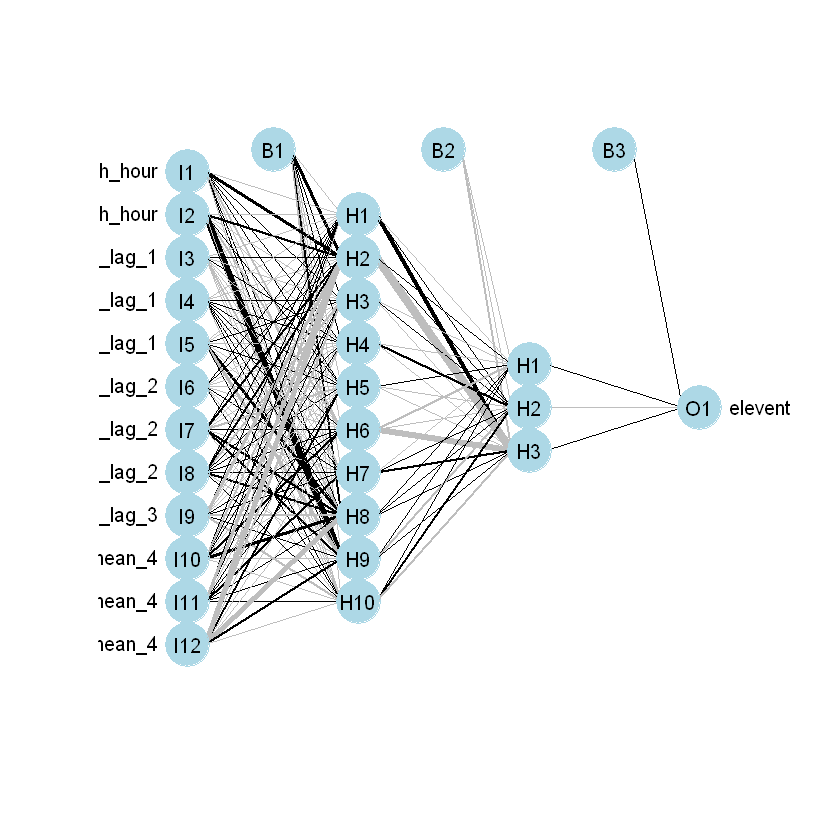

In [52]:
plotnet(best_nn)

In [53]:
rmse(truth_column,predicted_column)

[1] 3.693517

In [54]:
results_df

,date,actual,predicted
,<date>,<dbl>,<dbl>
431,2019-03-11,113.6,110.22966
432,2019-03-12,100.8,111.74400
433,2019-03-13,124.0,119.69028
434,2019-03-14,124.8,124.87102
435,2019-03-15,119.0,118.09625
436,2019-03-16,89.4,90.07865
437,2019-03-17,58.2,57.76734
438,2019-03-18,133.8,132.00848
439,2019-03-19,124.0,126.24820


In [55]:
summary(results_df)

      date                actual        predicted     
 Min.   :2019-03-11   Min.   : 48.2   Min.   : 54.03  
 1st Qu.:2019-03-26   1st Qu.: 91.0   1st Qu.: 92.58  
 Median :2019-04-11   Median :106.8   Median :107.59  
 Mean   :2019-04-11   Mean   :103.5   Mean   :103.83  
 3rd Qu.:2019-04-26   3rd Qu.:124.4   3rd Qu.:124.58  
 Max.   :2019-05-12   Max.   :140.8   Max.   :139.07  

In [56]:
# p = ggplot() + 
#   geom_line(data = results_df, aes(x = date, y = actual), color = "blue") +
#   geom_line(data = results_df, aes(x = date, y = predicted), color = "red") +
#   scale_color_manual(name = "energy level", values = c("actual" = "blue", "predicted" = "red"))+
#   xlab('Dates') +
#   ylab('eleventh hour energy level')

# print(p)

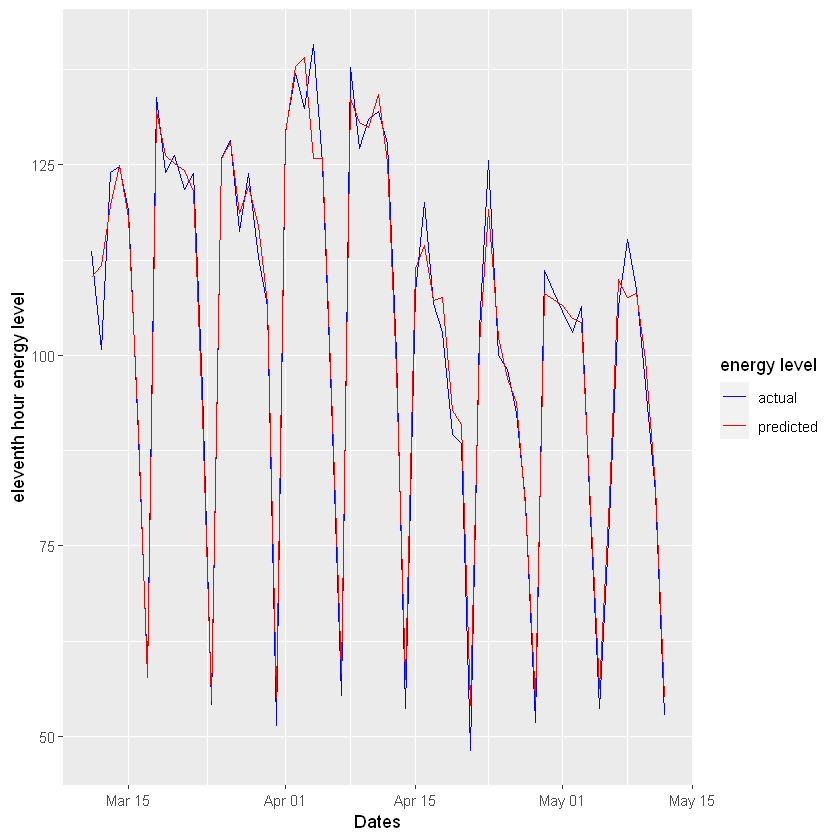

In [57]:
ggplot() +
  geom_line(data = results_df, aes(y = actual, x = date, colour = "actual")) +
  geom_line(data = results_df, aes(y = predicted, x = date, colour = "predicted")) +
  scale_color_manual(name = "energy level", values = c("actual" = "blue", "predicted" = "red")) +
  xlab('Dates') +
  ylab('eleventh hour energy level')